The Louvain algorithm involves randomness. The aim of this notebook is to run the Louvain algorithm multiple times and see how similar the communities it generates are.

Alex 22/09/2022

In [1]:
import networkx as nx
import numpy as np
import scipy as sp
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities
from community import community_louvain
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from utils import load_network
from tqdm import tqdm
import concurrent.futures 

G = load_network()

we run louvain 100 times and save the results to a file

next time we run the code, if the file exists we just load from that file instead of running louvain again (which will take forever)

In [2]:
import pickle

filename = 'louvain-runs.bin'
n_runs = 100

try:
    community_results = pickle.load(open(filename, 'rb'))
except:
    community_results = dict()
    # change max_workers to the number of processors on your machine
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:

        def thread_fn(i):
            community_results[i] = community_louvain.best_partition(G)
            print(f'run {i} done!') 

        executor.map(thread_fn, range(n_runs))
    pickle.dump(community_results, open(filename, 'wb'))

all proteins ['PDA1', 'PDB1', 'LAT1', 'LPD1'] belong to a single community, over all runs of Louvain!
intersection community size 62


{'ACH1',
 'ACO1',
 'ACO2',
 'ACS1',
 'ACS2',
 'ADY2',
 'AGC1',
 'AGP2',
 'AIM22',
 'ATO2',
 'CIT1',
 'CIT2',
 'CIT3',
 'CRC1',
 'CTP1',
 'DAL7',
 'DGR1',
 'DLD2',
 'DLD3',
 'FDH1',
 'FUM1',
 'GUT2',
 'HFA1',
 'ICL1',
 'ICL2',
 'IDH1',
 'IDH2',
 'IDP1',
 'IDP2',
 'IDP3',
 'IRC15',
 'IRC24',
 'JEN1',
 'KGD1',
 'KGD2',
 'LAT1',
 'LPD1',
 'LSC1',
 'LSC2',
 'MAE1',
 'MDH1',
 'MDH2',
 'MDH3',
 'MLS1',
 'NIT3',
 'ODC1',
 'ODC2',
 'PCK1',
 'PDA1',
 'PDB1',
 'PDX1',
 'PYC1',
 'PYC2',
 'SFC1',
 'UGA2',
 'YAT1',
 'YAT2',
 'YGR067C',
 'YIA6',
 'YIR035C',
 'YKL030W',
 'YSC83'}

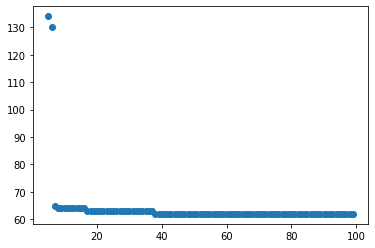

In [3]:
protein1 = ['PDA1', 'PDB1', 'LAT1', 'LPD1'] # pdh complex
protein2 = ['PKP1', 'PKP2', 'PTC5'] # pdh regulators

def check_same_communities(community_results, protein_list):
    bad_indices = set()
    for idx, communities in community_results.items():
        # print(communities)
        protein_comms = list(communities[p] for p in protein_list)
        identical_community = protein_comms.count(protein_comms[0]) == len(protein_comms)
        if not identical_community: 
            print(f"proteins in {protein_list} do not all belong to the same community, skipping this run!")
            bad_indices.add(idx)
    if len(bad_indices) == 0:
        print(f"all proteins {protein_list} belong to a single community, over all runs of Louvain!")
    
    each_community = list()
    intersection_sizes = list()
    for idx, communities in community_results.items():
        if idx in bad_indices:
            print(f'skipping {community_index}')
        else:
            # find thie community that the protein belongs to
            community_index = communities[protein_list[0]]
            protein_community = set(p for p in communities if communities[p] == community_index)
            # print(f'run {idx}, community size {len(protein_community)}')
            each_community.append(protein_community)
            intersection_sizes.append(len(set.intersection(*each_community)))
    print('intersection community size', len(set.intersection(*each_community)))
    
    # plt.plot(intersection_sizes, 'o')
    # plt.yscale('log')
    
    # ignore the first 10 intersects as they have very large sizes
    plt.plot(range(5,len(intersection_sizes)), intersection_sizes[5:], 'o')
    
    return set.intersection(*each_community)
        
check_same_communities(community_results, protein1)

Conclusion: after 100 runs of Louvain, the four proteins 'PDA1', 'PDB1', 'LAT1', 'LPD1' are always part of the same community. Moreover, for each run the same 62 proteins are present (these are the ones printed above).

proteins in ['PKP1', 'PKP2', 'PTC5'] do not all belong to the same community, skipping this run!
skipping 5
intersection community size 3


{'PKP1', 'PKP2', 'PTC5'}

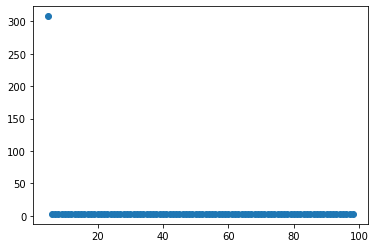

In [4]:
check_same_communities(community_results, protein2)

On the other hand, out of those same 100 runs of Louvain, the three proteins 'PKP1', 'PKP2', 'PTC5' formed part of the same community in all but one of the runs. For those 99 runs, there are no other proteins common in all runs to the same community as the three proteins.